In [1]:
import numpy as np
import ROOT
from math import exp as expo
from math import cos as cosine
from math import sin as sine
sin=np.vectorize(sine)
exp=np.vectorize(expo)
cos=np.vectorize(cosine)
import matplotlib.pylab as plt
from matplotlib.pyplot import figure
from BlindersPy3 import Blinders
from BlindersPy3 import FitType
import scipy.optimize as opt

Welcome to JupyROOT 6.24/06


In [2]:
file = ROOT.TFile.Open("run2_4hcopy_ratioFR_percalo_cov_mat_final.root")
hist_tmp = ROOT.TH1D()
hist_tmp = file.Get("hcalo_ratio_1")

In [3]:
fit_start=30000
fit_stop=300000
fit_range=hist_tmp.FindBin(fit_stop)-hist_tmp.FindBin(fit_start)+1
y_val=np.empty(shape=(24,fit_range))
y_err=np.empty(shape=(24,fit_range))
x_val=np.empty(shape=(24,fit_range))
y_cov=np.empty(shape=(24,fit_range,fit_range))  

In [4]:
%%time
for icalo in range(0,24):
    hist = ROOT.TH1D()
    hcov = ROOT.TH2D()
    hist = file.Get("hcalo_ratio_"+str(icalo+1))
    for ibin in range (0,fit_range):
        y_val[icalo][ibin]=hist.GetBinContent(ibin+hist.FindBin(fit_start))
        y_err[icalo][ibin]=hist.GetBinError(ibin+hist.FindBin(fit_start))
        x_val[icalo][ibin]=hist.GetBinCenter(ibin+hist.FindBin(fit_start))
        
    hcov = file.Get("hcov_"+str(icalo+1))
    for irow in range (0, fit_range):
        for icol in range(0, fit_range):
            y_cov[icalo][irow][icol]=hcov.GetBinContent(irow+hist.FindBin(fit_start),icol+hist.FindBin(fit_start))
            
    hist.Reset()
    hcov.Reset()

CPU times: user 2min 54s, sys: 37 s, total: 3min 31s
Wall time: 3min 31s


In [5]:
getBlinded = Blinders(FitType.Omega_a, "Ritwika's new  Blinding")

 + ++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++ +
 +                                                                      +
 +           You have chose to blind your fitting according to          +
 +                omega_ref * (1 + (R +/- deltaR) *10^{-6})             +
 +                                                                      +
 + ++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++ +


In [6]:
T_a_true=4365.411
nbinshift=int((0.5*T_a_true)/hist.GetBinWidth(1))
T_a=2*nbinshift*hist.GetBinWidth(1)

asym=np.empty(24)
dasym=np.empty(24)
rval=np.empty(24)
drval=np.empty(24)
phi=np.empty(24)
dphi=np.empty(24)
A_cbo=np.empty(24)
dA_cbo=np.empty(24)
tau_cbo=np.empty(24)
dtau_cbo=np.empty(24)
omega_cbo=np.empty(24)
domega_cbo=np.empty(24)
phi_cbo=np.empty(24)
dphi_cbo=np.empty(24)
A_cbo_A=np.empty(24)
dA_cbo_A=np.empty(24)
phi_cbo_A=np.empty(24)
dphi_cbo_A=np.empty(24)
A_cbo_phi=np.empty(24)
dA_cbo_phi=np.empty(24)
phi_cbo_phi=np.empty(24)
dphi_cbo_phi=np.empty(24)
A_vw=np.empty(24)
dA_vw=np.empty(24)
tau_vw=np.empty(24)
dtau_vw=np.empty(24)
omega_vw=np.empty(24)
domega_vw=np.empty(24)
phi_vw=np.empty(24)
dphi_vw=np.empty(24)
A_y=np.empty(24)
dA_y=np.empty(24)
tau_y=np.empty(24)
dtau_y=np.empty(24)
omega_y=np.empty(24)
domega_y=np.empty(24)
phi_y=np.empty(24)
dphi_y=np.empty(24)
A_2cbo=np.empty(24)
dA_2cbo=np.empty(24)
tau_2cbo=np.empty(24)
dtau_2cbo=np.empty(24)
omega_2cbo=np.empty(24)
domega_2cbo=np.empty(24)
phi_2cbo=np.empty(24)
dphi_2cbo=np.empty(24)
calonum=np.empty(24)


In [7]:
def fit_func3(time: np.double,
              asym: np.double = 0.0, 
              R: np.double = 0.0, 
              phi: np.double = 0.0)-> np.double:
    
    f=(1+ asym*cos((getBlinded.paramToFreq(R)/1000.)*time - phi))

    ff=(1+ asym*cos((getBlinded.paramToFreq(R)/1000.)*(time + T_a/2) - phi))

    fb=(1+ asym*cos((getBlinded.paramToFreq(R)/1000.)*(time - T_a/2) - phi))

    
    return (2*f - ff - fb)/(2*f + ff + fb) 

In [8]:
def fit_func7(time: np.double,
              asym: np.double = 0.0, 
              R: np.double = 0.0, 
              phi: np.double = 0.0,
              asym_cbo = 0.0,
              tau_cbo = 0.0,
              omega_cbo = 0.0,
              phi_cbo = 0.0)-> np.double:
    
    Ncbo=(1 + asym_cbo*exp(-time/tau_cbo)*cos(omega_cbo*time - phi_cbo))
    Ncbof=(1+ asym_cbo*exp(-(time + T_a/2)/tau_cbo)*cos(omega_cbo*(time + T_a/2) - phi_cbo))
    Ncbob=(1+ asym_cbo*exp(-(time - T_a/2)/tau_cbo)*cos(omega_cbo*(time - T_a/2) - phi_cbo))

    f=(1+ asym*cos((getBlinded.paramToFreq(R)/1000.)*time - phi))

    ff=(1+ asym*cos((getBlinded.paramToFreq(R)/1000.)*(time + T_a/2) - phi))

    fb=(1+ asym*cos((getBlinded.paramToFreq(R)/1000.)*(time - T_a/2) - phi))

    
    return (2*f*Ncbo - ff*Ncbof - fb*Ncbob)/(2*f*Ncbo + ff*Ncbof + fb*Ncbob)

In [9]:
def fit_func11(time: np.double,
               asym: np.double = 0.0, 
               R: np.double = 0.0, 
               phi: np.double = 0.0,
               asym_cbo = 0.0,
               tau_cbo = 0.0,
               omega_cbo = 0.0,
               phi_cbo = 0.0,
               asym_cbo_A = 0.0,
               phi_cbo_A=0.0,
               A_cbo_phi= 0.0,
               phi_cbo_phi=0.0)-> np.double:
    
    Ncbo=(1 + asym_cbo*exp(-time/tau_cbo)*cos(omega_cbo*time - phi_cbo))
    Ncbof=(1+ asym_cbo*exp(-(time + T_a/2)/tau_cbo)*cos(omega_cbo*(time + T_a/2) - phi_cbo))
    Ncbob=(1+ asym_cbo*exp(-(time - T_a/2)/tau_cbo)*cos(omega_cbo*(time - T_a/2) - phi_cbo))
    Acbo=(1+ asym_cbo_A*exp(-time/tau_cbo)*cos(omega_cbo*time - phi_cbo_A));
    Acbof=(1+ asym_cbo_A*exp(-(time + T_a/2)/tau_cbo)*cos(omega_cbo*(time + T_a/2) - phi_cbo_A))
    Acbob=(1+ asym_cbo_A*exp(-(time - T_a/2)/tau_cbo)*cos(omega_cbo*(time - T_a/2) - phi_cbo_A))
    phicbo=(A_cbo_phi*exp(-time/tau_cbo)*cos(omega_cbo*time - phi_cbo_phi))
    phicbof=(A_cbo_phi*exp(-(time + T_a/2)/tau_cbo)*cos(omega_cbo*(time + T_a/2) - phi_cbo_phi))
    phicbob=(A_cbo_phi*exp(-(time - T_a/2)/tau_cbo)*cos(omega_cbo*(time - T_a/2) - phi_cbo_phi))


    f=(1+ asym*Acbo*cos((getBlinded.paramToFreq(R)/1000.)*time - phi - phicbo))

    ff=(1+ asym*Acbof*cos((getBlinded.paramToFreq(R)/1000.)*(time + T_a/2) - phi - phicbof))

    fb=(1+ asym*Acbob*cos((getBlinded.paramToFreq(R)/1000.)*(time - T_a/2) - phi - phicbob))

    
    return (2*f*Ncbo - ff*Ncbof - fb*Ncbob)/(2*f*Ncbo + ff*Ncbof + fb*Ncbob)

In [10]:
def fit_func15(time: np.double,
               asym: np.double = 0.0, 
               R: np.double = 0.0, 
               phi: np.double = 0.0,
               asym_cbo = 0.0,
               tau_cbo = 0.0,
               omega_cbo = 0.0,
               phi_cbo = 0.0,
               asym_cbo_A = 0.0,
               phi_cbo_A=0.0,
               A_cbo_phi= 0.0,
               phi_cbo_phi=0.0,
               asym_2cbo= 0.0,
               phi_2cbo = 0.0)-> np.double:
    
    Ncbo=(1 + asym_cbo*exp(-time/tau_cbo)*cos(omega_cbo*time - phi_cbo))
    Ncbof=(1+ asym_cbo*exp(-(time + T_a/2)/tau_cbo)*cos(omega_cbo*(time + T_a/2) - phi_cbo))
    Ncbob=(1+ asym_cbo*exp(-(time - T_a/2)/tau_cbo)*cos(omega_cbo*(time - T_a/2) - phi_cbo))
    Acbo=(1+ asym_cbo_A*exp(-time/tau_cbo)*cos(omega_cbo*time - phi_cbo_A));
    Acbof=(1+ asym_cbo_A*exp(-(time + T_a/2)/tau_cbo)*cos(omega_cbo*(time + T_a/2) - phi_cbo_A))
    Acbob=(1+ asym_cbo_A*exp(-(time - T_a/2)/tau_cbo)*cos(omega_cbo*(time - T_a/2) - phi_cbo_A))
    phicbo=(A_cbo_phi*exp(-time/tau_cbo)*cos(omega_cbo*time - phi_cbo_phi))
    phicbof=(A_cbo_phi*exp(-(time + T_a/2)/tau_cbo)*cos(omega_cbo*(time + T_a/2) - phi_cbo_phi))
    phicbob=(A_cbo_phi*exp(-(time - T_a/2)/tau_cbo)*cos(omega_cbo*(time - T_a/2) - phi_cbo_phi))
    N2cbo=(asym_2cbo*exp(-time/(tau_cbo/2))*cos(2*omega_cbo*time - phi_2cbo))
    N2cbof=(asym_2cbo*exp(-(time + T_a/2)/(tau_cbo/2))*cos(2*omega_cbo*(time + T_a/2) - phi_2cbo))
    N2cbob=(asym_2cbo*exp(-(time - T_a/2)/(tau_cbo/2))*cos(2*omega_cbo*(time - T_a/2) - phi_2cbo))

    Ncbo=Ncbo+N2cbo
    Ncbof=Ncbof+N2cbof
    Ncbob=Ncbob+N2cbob

    f=(1+ asym*Acbo*cos((getBlinded.paramToFreq(R)/1000.)*time - phi - phicbo))

    ff=(1+ asym*Acbof*cos((getBlinded.paramToFreq(R)/1000.)*(time + T_a/2) - phi - phicbof))

    fb=(1+ asym*Acbob*cos((getBlinded.paramToFreq(R)/1000.)*(time - T_a/2) - phi - phicbob))

    
    return (2*f*Ncbo - ff*Ncbof - fb*Ncbob)/(2*f*Ncbo + ff*Ncbof + fb*Ncbob)

In [11]:
def fit_func19(time: np.double,
               asym: np.double = 0.0, 
               R: np.double = 0.0, 
               phi: np.double = 0.0,
               asym_cbo = 0.0,
               tau_cbo = 0.0,
               omega_cbo = 0.0,
               phi_cbo = 0.0,
               asym_cbo_A = 0.0,
               phi_cbo_A=0.0,
               A_cbo_phi= 0.0,
               phi_cbo_phi=0.0,
               asym_2cbo= 0.0,
               phi_2cbo = 0.0,
               asym_vw= 0.0,
               phi_vw = 0.0)-> np.double:
    
    tau_vw = 94208
    omega_vw = 0.01392

    
    Ncbo=(1 + asym_cbo*exp(-time/tau_cbo)*cos(omega_cbo*time - phi_cbo))
    Ncbof=(1+ asym_cbo*exp(-(time + T_a/2)/tau_cbo)*cos(omega_cbo*(time + T_a/2) - phi_cbo))
    Ncbob=(1+ asym_cbo*exp(-(time - T_a/2)/tau_cbo)*cos(omega_cbo*(time - T_a/2) - phi_cbo))
    Acbo=(1+ asym_cbo_A*exp(-time/tau_cbo)*cos(omega_cbo*time - phi_cbo_A));
    Acbof=(1+ asym_cbo_A*exp(-(time + T_a/2)/tau_cbo)*cos(omega_cbo*(time + T_a/2) - phi_cbo_A))
    Acbob=(1+ asym_cbo_A*exp(-(time - T_a/2)/tau_cbo)*cos(omega_cbo*(time - T_a/2) - phi_cbo_A))
    phicbo=(A_cbo_phi*exp(-time/tau_cbo)*cos(omega_cbo*time - phi_cbo_phi))
    phicbof=(A_cbo_phi*exp(-(time + T_a/2)/tau_cbo)*cos(omega_cbo*(time + T_a/2) - phi_cbo_phi))
    phicbob=(A_cbo_phi*exp(-(time - T_a/2)/tau_cbo)*cos(omega_cbo*(time - T_a/2) - phi_cbo_phi))
    N2cbo=(asym_2cbo*exp(-time/(tau_cbo/2))*cos(2*omega_cbo*time - phi_2cbo))
    N2cbof=(asym_2cbo*exp(-(time + T_a/2)/(tau_cbo/2))*cos(2*omega_cbo*(time + T_a/2) - phi_2cbo))
    N2cbob=(asym_2cbo*exp(-(time - T_a/2)/(tau_cbo/2))*cos(2*omega_cbo*(time - T_a/2) - phi_2cbo))
    Nvw=(1+ asym_vw*exp(-time/tau_vw)*cos(omega_vw*time - phi_vw))
    Nvwf=(1+ asym_vw*exp(-(time + T_a/2)/tau_vw)*cos(omega_vw*(time + T_a/2) - phi_vw))
    Nvwb=(1+ asym_vw*exp(-(time - T_a/2)/tau_vw)*cos(omega_vw*(time - T_a/2) - phi_vw))

    
    Ncbo=Ncbo+N2cbo
    Ncbof=Ncbof+N2cbof
    Ncbob=Ncbob+N2cbob

    f=(1+ asym*Acbo*cos((getBlinded.paramToFreq(R)/1000.)*time - phi - phicbo))

    ff=(1+ asym*Acbof*cos((getBlinded.paramToFreq(R)/1000.)*(time + T_a/2) - phi - phicbof))

    fb=(1+ asym*Acbob*cos((getBlinded.paramToFreq(R)/1000.)*(time - T_a/2) - phi - phicbob))

    
    return (2*f*Ncbo*Nvw - ff*Ncbof*Nvwf - fb*Ncbob*Nvwb)/(2*f*Ncbo*Nvw + ff*Ncbof*Nvwf + fb*Ncbob*Nvwb)

In [12]:
def fit_func23(time: np.double,
               asym: np.double = 0.0, 
               R: np.double = 0.0, 
               phi: np.double = 0.0,
               asym_cbo = 0.0,
               tau_cbo = 0.0,
               omega_cbo = 0.0,
               phi_cbo = 0.0,
               asym_cbo_A = 0.0,
               phi_cbo_A=0.0,
               A_cbo_phi= 0.0,
               phi_cbo_phi=0.0,
               asym_2cbo= 0.0,
               phi_2cbo = 0.0,
               asym_vw= 0.0,
               phi_vw = 0.0,
               asym_vbo= 0.0,
               phi_vbo = 0.0)-> np.double:
    
    tau_vw = 94208
    omega_vw = 0.01392
    
    tau_vbo = 25630
    omega_vbo = 0.01402

    
    Ncbo=(1 + asym_cbo*exp(-time/tau_cbo)*cos(omega_cbo*time - phi_cbo))
    Ncbof=(1+ asym_cbo*exp(-(time + T_a/2)/tau_cbo)*cos(omega_cbo*(time + T_a/2) - phi_cbo))
    Ncbob=(1+ asym_cbo*exp(-(time - T_a/2)/tau_cbo)*cos(omega_cbo*(time - T_a/2) - phi_cbo))
    Acbo=(1+ asym_cbo_A*exp(-time/tau_cbo)*cos(omega_cbo*time - phi_cbo_A));
    Acbof=(1+ asym_cbo_A*exp(-(time + T_a/2)/tau_cbo)*cos(omega_cbo*(time + T_a/2) - phi_cbo_A))
    Acbob=(1+ asym_cbo_A*exp(-(time - T_a/2)/tau_cbo)*cos(omega_cbo*(time - T_a/2) - phi_cbo_A))
    phicbo=(A_cbo_phi*exp(-time/tau_cbo)*cos(omega_cbo*time - phi_cbo_phi))
    phicbof=(A_cbo_phi*exp(-(time + T_a/2)/tau_cbo)*cos(omega_cbo*(time + T_a/2) - phi_cbo_phi))
    phicbob=(A_cbo_phi*exp(-(time - T_a/2)/tau_cbo)*cos(omega_cbo*(time - T_a/2) - phi_cbo_phi))
    N2cbo=(asym_2cbo*exp(-time/(tau_cbo/2))*cos(2*omega_cbo*time - phi_2cbo))
    N2cbof=(asym_2cbo*exp(-(time + T_a/2)/(tau_cbo/2))*cos(2*omega_cbo*(time + T_a/2) - phi_2cbo))
    N2cbob=(asym_2cbo*exp(-(time - T_a/2)/(tau_cbo/2))*cos(2*omega_cbo*(time - T_a/2) - phi_2cbo))
    Nvw=(1+ asym_vw*exp(-time/tau_vw)*cos(omega_vw*time - phi_vw))
    Nvwf=(1+ asym_vw*exp(-(time + T_a/2)/tau_vw)*cos(omega_vw*(time + T_a/2) - phi_vw))
    Nvwb=(1+ asym_vw*exp(-(time - T_a/2)/tau_vw)*cos(omega_vw*(time - T_a/2) - phi_vw))
    Nvbo=(1+ asym_vbo*exp(-time/tau_vbo)*cos(omega_vbo*time - phi_vbo))
    Nvbof=(1+ asym_vbo*exp(-(time + T_a/2)/tau_vbo)*cos(omega_vbo*(time + T_a/2) - phi_vbo))
    Nvbob=(1+ asym_vbo*exp(-(time - T_a/2)/tau_vbo)*cos(omega_vbo*(time - T_a/2) - phi_vbo))


    
    Ncbo=Ncbo+N2cbo
    Ncbof=Ncbof+N2cbof
    Ncbob=Ncbob+N2cbob

    f=(1+ asym*Acbo*cos((getBlinded.paramToFreq(R)/1000.)*time - phi - phicbo))

    ff=(1+ asym*Acbof*cos((getBlinded.paramToFreq(R)/1000.)*(time + T_a/2) - phi - phicbof))

    fb=(1+ asym*Acbob*cos((getBlinded.paramToFreq(R)/1000.)*(time - T_a/2) - phi - phicbob))

    
    return (2*f*Ncbo*Nvw*Nvbo - ff*Ncbof*Nvwf*Nvbof - fb*Ncbob*Nvwb*Nvbob)/(2*f*Ncbo*Nvw*Nvbo + ff*Ncbof*Nvwf*Nvbof + fb*Ncbob*Nvwb*Nvbob)

In [13]:
p_init3=[2.28839e-01,
        0.000000,
        4.02055e+00]

In [14]:
%%time
for icalo in range(0,24): 
    pars3, cov3 = opt.curve_fit(f=fit_func3, xdata=x_val[icalo], ydata=y_val[icalo], p0=p_init3, sigma=y_err[icalo]) 
    
    p_init7=[pars3[0],
             pars3[1],
             pars3[2],
             0.02,
             240000,
             0.0023404,
             2.00+(icalo*(6.28/24))]
    
    pars7, cov7 = opt.curve_fit(f=fit_func7, xdata=x_val[icalo], ydata=y_val[icalo], p0=p_init7, sigma=y_err[icalo])
    
    p_init11=[pars7[0],
              pars7[1],
              pars7[2],
              pars7[3],
              pars7[4],
              pars7[5],
              pars7[6],
              0.02,
              1.1,
              0.003,
              1.2]
    
    pars11, cov11 = opt.curve_fit(f=fit_func11, xdata=x_val[icalo], ydata=y_val[icalo], p0=p_init11, sigma=y_err[icalo])
    
    p_init15=[pars11[0],
              pars11[1],
              pars11[2],
              pars11[3],
              pars11[4],
              pars11[5],
              pars11[6],
              pars11[7],
              pars11[8],
              pars11[9],
              pars11[10],
              0.001,
              5.1]
    
    pars15, cov15 = opt.curve_fit(f=fit_func15, xdata=x_val[icalo], ydata=y_val[icalo], p0=p_init15, sigma=y_err[icalo])

    p_init19=[pars15[0],
              pars15[1],
              pars15[2],
              pars15[3],
              pars15[4],
              pars15[5],
              pars15[6],
              pars15[7],
              pars15[8],
              pars15[9],
              pars15[10],
              pars15[11],
              pars15[12],
              0.0005,
              3.5]
    
    pars19, cov19 = opt.curve_fit(f=fit_func19, xdata=x_val[icalo], ydata=y_val[icalo], p0=p_init19, sigma=y_err[icalo])

    p_init23=[pars19[0],
              pars19[1],
              pars19[2],
              pars19[3],
              pars19[4],
              pars19[5],
              pars19[6],
              pars19[7],
              pars19[8],
              pars19[9],
              pars19[10],
              pars19[11],
              pars19[12],
              pars19[13],
              pars19[14],
              0.001,
              4.2]
    
    pars23, cov23 = opt.curve_fit(f=fit_func23, xdata=x_val[icalo], ydata=y_val[icalo], p0=p_init23, sigma=y_err[icalo])

    p_init_final=pars23
    
    pars2, cov_final = opt.curve_fit(f=fit_func23, xdata=x_val[icalo], ydata=y_val[icalo], p0=p_init_final, sigma=y_cov[icalo])
    
    stdevs=np.sqrt(np.diag(cov_final))
    
    calonum[icalo]=icalo+1
    
    asym[icalo]=pars2[0]
    dasym[icalo]=stdevs[0]
    rval[icalo]=pars2[1]
    drval[icalo]=stdevs[1]
    phi[icalo]=pars2[2]
    dphi[icalo]=stdevs[2]
    A_cbo[icalo]=pars2[3]
    dA_cbo[icalo]=stdevs[3]
    tau_cbo[icalo]=pars2[4]
    dtau_cbo[icalo]=stdevs[4]
    omega_cbo[icalo]=pars2[5]
    domega_cbo[icalo]=stdevs[5]
    phi_cbo[icalo]=pars2[6]
    dphi_cbo[icalo]=stdevs[6]
    A_cbo_A[icalo]=pars2[7]
    dA_cbo_A[icalo]=stdevs[7]
    phi_cbo_A[icalo]=pars2[8]
    dphi_cbo_A[icalo]=stdevs[8]
    A_cbo_phi[icalo]=pars2[9]
    dA_cbo_phi[icalo]=stdevs[9]
    phi_cbo_phi[icalo]=pars2[10]
    dphi_cbo_phi[icalo]=stdevs[10]
    A_2cbo[icalo]=pars2[11]
    dA_2cbo[icalo]=stdevs[11]
    phi_2cbo[icalo]=pars2[12]
    dphi_2cbo[icalo]=stdevs[12]
    A_y[icalo]=pars2[13]
    dA_y[icalo]=stdevs[13]
    phi_y[icalo]=pars2[14]
    dphi_y[icalo]=stdevs[14]
    A_vw[icalo]=pars2[15]
    dA_vw[icalo]=stdevs[15]
    phi_vw[icalo]=pars2[16]
    dphi_vw[icalo]=stdevs[16]
        
    


CPU times: user 1min 28s, sys: 16.9 s, total: 1min 45s
Wall time: 1min 9s


In [15]:
stdevs

array([4.33675221e-05, 2.35932666e+00, 3.58646213e-04, 1.24043239e-04,
       3.56909069e+03, 5.73801330e-08, 4.74514928e-03, 3.70633847e-04,
       1.90727094e-02, 3.70119582e-04, 1.59404819e-01, 7.87335954e-05,
       1.04662787e-01, 8.51024399e-05, 2.24443204e-01, 3.03446184e-04,
       1.08533201e-01])

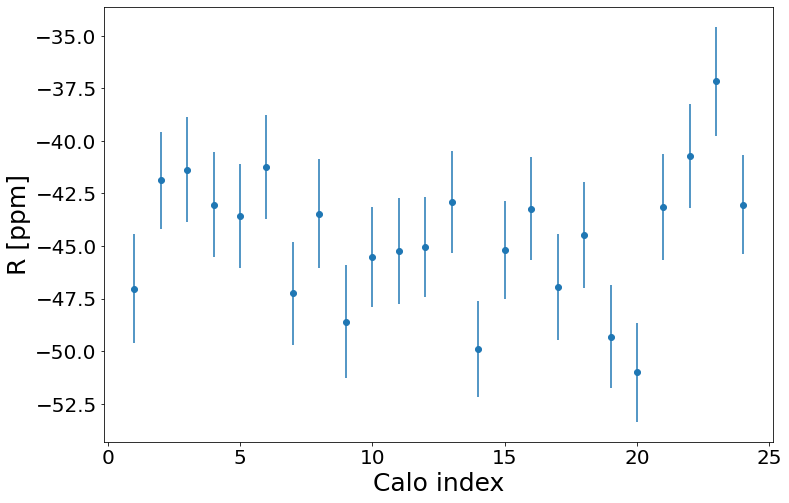

In [16]:
plt.figure(figsize=(12,8))
plt.rc('xtick', labelsize=20) 
plt.rc('ytick', labelsize=20) 
plt.errorbar(calonum, rval, yerr=drval, fmt="o")
plt.xlabel('Calo index',fontsize=25)
plt.ylabel('R [ppm]',fontsize=25)
plt.show()
#plt.savefig('run2_caloscan_R.jpg')

In [17]:
def fit_Rwave(x: np.double,
              amp: np.double = 0.0, 
              phase: np.double = 0.0, 
              offset: np.double = 0.0)-> np.double:
    
    Romega=0.2618
    
    return amp*sin(Romega*x+phase)+offset

p_0=[1.0,1.5,-45]

rwave_p, rwave_cov = opt.curve_fit(f=fit_Rwave, xdata=calonum, ydata=rval, p0=p_0, sigma=drval)

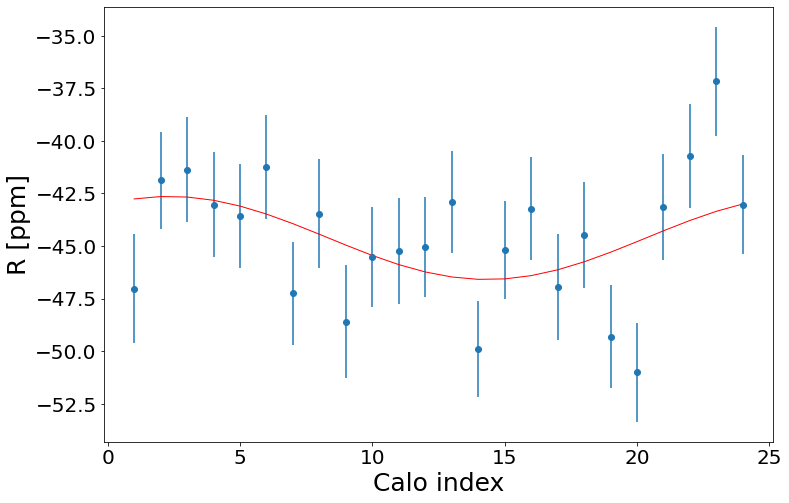

chi2/ndf= 31.84868176381224 /21
amplitude= 1.9761735677674281  phase= 0.9581830422002533  offset= -44.61625254991163


In [18]:
plt.figure(figsize=(12,8))
plt.rc('xtick', labelsize=20) 
plt.rc('ytick', labelsize=20) 
plt.errorbar(calonum, rval, yerr=drval, fmt="o")
plt.plot(calonum, fit_Rwave(calonum, *rwave_p), linestyle='solid', linewidth=1, color='red')
plt.xlabel('Calo index',fontsize=25)
plt.ylabel('R [ppm]',fontsize=25)
plt.show()
chi2_1=np.empty(24)
chi2_1=(fit_Rwave(calonum, *rwave_p)-rval)*(fit_Rwave(calonum, *rwave_p)-rval)/(drval*drval)
print('chi2/ndf=',sum(chi2_1),'/21')
print('amplitude=',rwave_p[0],' phase=',rwave_p[1],' offset=',rwave_p[2])
#plt.savefig('run2_caloscan_Rfit_sine.jpg')

In [19]:
def fit_straight(x: np.double, 
                 offset: np.double = 0.0)-> np.double:
    
    return offset+0*x

p2_0=[-45]

rwave2_p, rwave2_cov = opt.curve_fit(f=fit_straight, xdata=calonum, ydata=rval, p0=p2_0, sigma=drval)

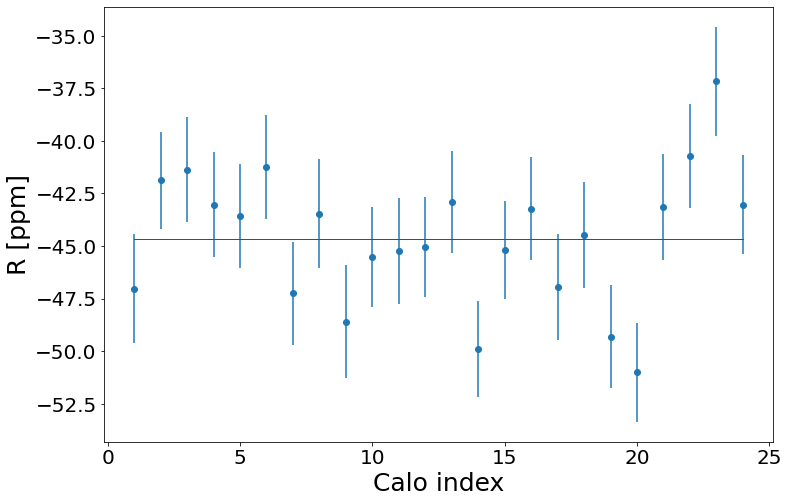

chi2/ndf= 39.804306128695416 /23
offset= -44.64380075909


In [20]:
plt.figure(figsize=(12,8))
plt.rc('xtick', labelsize=20) 
plt.rc('ytick', labelsize=20) 
plt.errorbar(calonum, rval, yerr=drval, fmt="o")
plt.plot(calonum, fit_straight(calonum, *rwave2_p), linestyle='solid', linewidth=1, color='red')
plt.xlabel('Calo index',fontsize=25)
plt.ylabel('R [ppm]',fontsize=25)
plt.show()
chi2_2=np.empty(24)
chi2_2=(fit_straight(calonum, *rwave2_p)-rval)*(fit_straight(calonum, *rwave2_p)-rval)/(drval*drval)
print('chi2/ndf=',sum(chi2_2),'/23')
print('offset=',rwave2_p[0])
#plt.savefig('run2_caloscan_Rfit_straight.jpg')

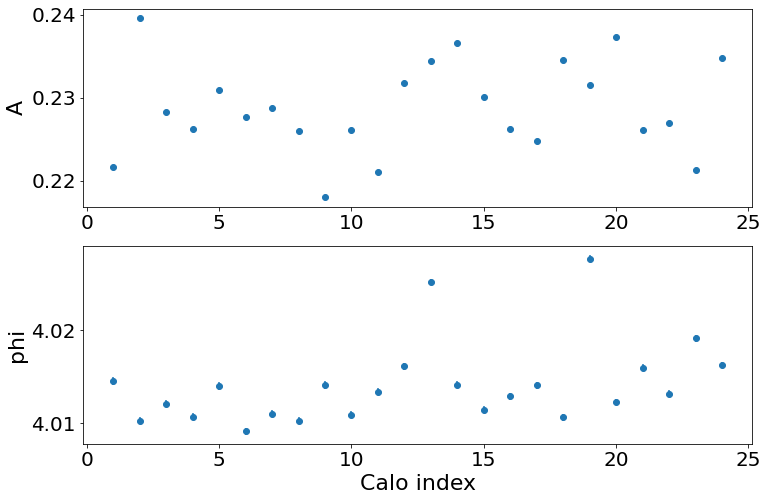

In [21]:
plt.figure(figsize=(12,8))
# fist line:
plt.subplot(211)
plt.rc('xtick', labelsize=20) 
plt.rc('ytick', labelsize=20) 
plt.errorbar(calonum, asym, yerr=dasym, fmt="o")
plt.ylabel('A',fontsize=22)
 
# second line
plt.subplot(212)
plt.rc('xtick', labelsize=20) 
plt.rc('ytick', labelsize=20) 
plt.errorbar(calonum, phi, yerr=dphi, fmt="o")
plt.xlabel('Calo index',fontsize=22)
plt.ylabel('phi',fontsize=22)

plt.show()
#plt.savefig('run2_caloscan_A_phi.jpg')

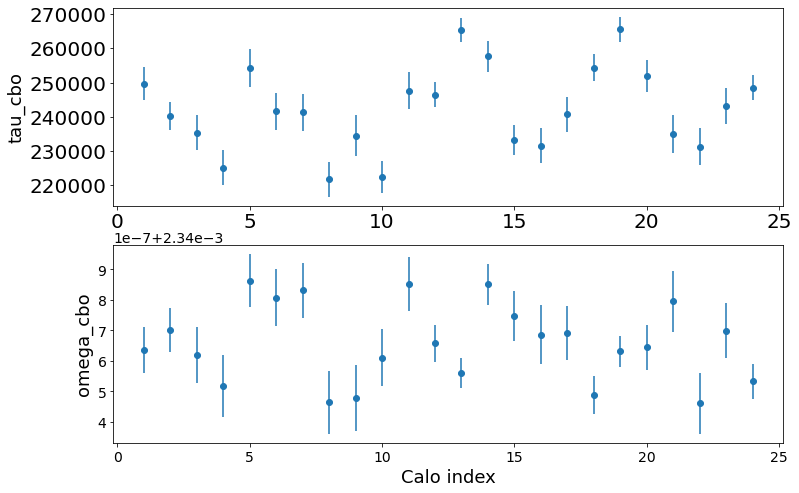

In [22]:
plt.figure(figsize=(12,8))
# fist line:
plt.subplot(211)
plt.rc('xtick', labelsize=14) 
plt.rc('ytick', labelsize=14) 
plt.errorbar(calonum, tau_cbo, yerr=dtau_cbo, fmt="o")
plt.ylabel('tau_cbo',fontsize=18)
 
# second line
plt.subplot(212)
plt.rc('xtick', labelsize=14) 
plt.rc('ytick', labelsize=14) 
plt.errorbar(calonum, omega_cbo, yerr=domega_cbo, fmt="o")
plt.xlabel('Calo index',fontsize=18)
plt.ylabel('omega_cbo',fontsize=18)

plt.show()
#plt.savefig('run2_caloscan_tau_omega_cbo.jpg')

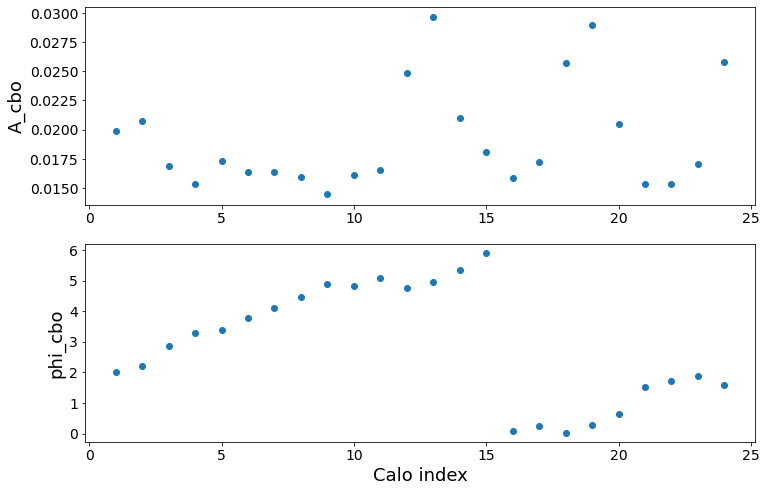

In [23]:
plt.figure(figsize=(12,8))
# fist line:
plt.subplot(211)
plt.rc('xtick', labelsize=14) 
plt.rc('ytick', labelsize=14) 
plt.errorbar(calonum, A_cbo, yerr=dA_cbo, fmt="o")
plt.ylabel('A_cbo',fontsize=18)

for icalo in range(0,24):
    if phi_cbo[icalo]>6.28:
        phi_cbo[icalo]=phi_cbo[icalo]-6.28

# second line
plt.subplot(212)
plt.rc('xtick', labelsize=14) 
plt.rc('ytick', labelsize=14) 
plt.errorbar(calonum, phi_cbo, yerr=dphi_cbo, fmt="o")
plt.xlabel('Calo index',fontsize=18)
plt.ylabel('phi_cbo',fontsize=18)

plt.show()
#plt.savefig('run2_caloscan_A_phi_cbo.jpg')

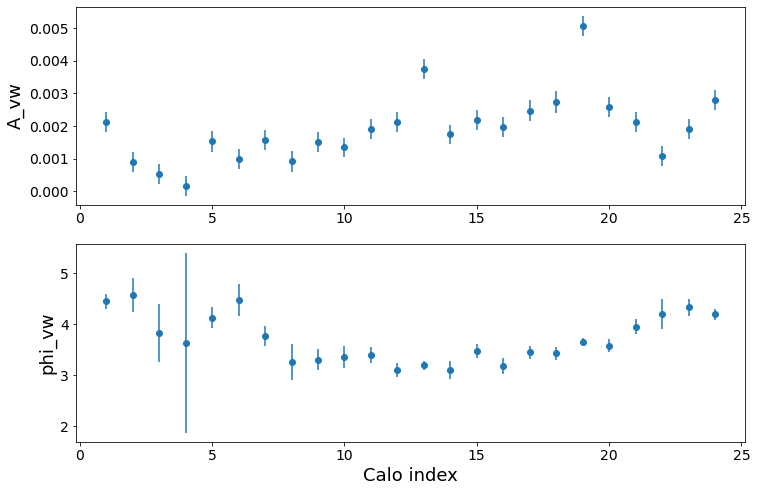

In [24]:
plt.figure(figsize=(12,8))
# fist line:
plt.subplot(211)
plt.rc('xtick', labelsize=14) 
plt.rc('ytick', labelsize=14) 
plt.errorbar(calonum, np.abs(A_vw), yerr=dA_vw, fmt="o")
plt.ylabel('A_vw',fontsize=18)

for icalo in range(0,24):
    if phi_vw[icalo]>6.28:
        phi_vw[icalo]=phi_vw[icalo]-6.28

# second line
plt.subplot(212)
plt.rc('xtick', labelsize=14) 
plt.rc('ytick', labelsize=14) 
plt.errorbar(calonum, phi_vw, yerr=dphi_vw, fmt="o")
plt.xlabel('Calo index',fontsize=18)
plt.ylabel('phi_vw',fontsize=18)

plt.show()
#plt.savefig('run2_caloscan_A_phi_vw.jpg')

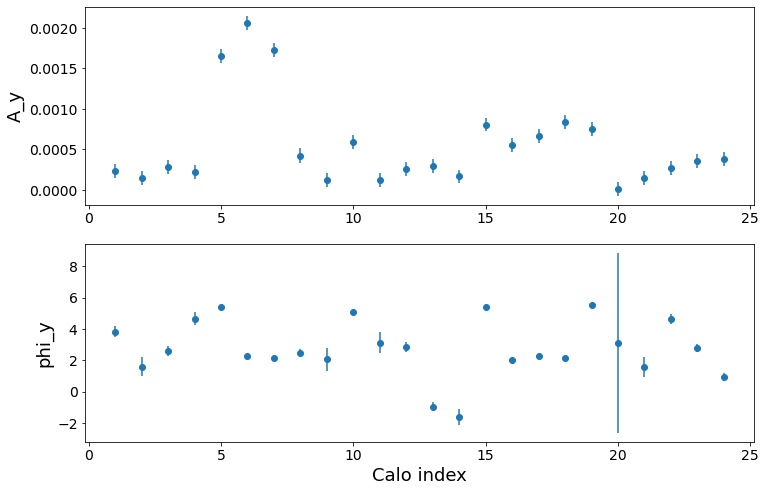

In [25]:
plt.figure(figsize=(12,8))
# fist line:
plt.subplot(211)
plt.rc('xtick', labelsize=14) 
plt.rc('ytick', labelsize=14) 
plt.errorbar(calonum, np.abs(A_y), yerr=dA_y, fmt="o")
plt.ylabel('A_y',fontsize=18)

for icalo in range(0,24):
    if phi_y[icalo]>6.28:
        phi_y[icalo]=phi_y[icalo]-6.28

# second line
plt.subplot(212)
plt.rc('xtick', labelsize=14) 
plt.rc('ytick', labelsize=14) 
plt.errorbar(calonum, phi_y, yerr=dphi_y, fmt="o")
plt.xlabel('Calo index',fontsize=18)
plt.ylabel('phi_y',fontsize=18)

plt.show()
#plt.savefig('run2_caloscan_A_phi_y.jpg')

In [26]:
rval

array([-47.0200763 , -41.88357472, -41.36417967, -43.0295705 ,
       -43.58594032, -41.23972122, -47.25112343, -43.46892638,
       -48.59689295, -45.52111138, -45.24020215, -45.05842311,
       -42.90527401, -49.89961501, -45.18747758, -43.21928885,
       -46.96901034, -44.49042263, -49.30985929, -51.01417521,
       -43.14452618, -40.71208803, -37.17003715, -43.0325519 ])

In [27]:
drval

array([2.57776073, 2.29804067, 2.49348973, 2.49320118, 2.47953261,
       2.4898838 , 2.45846798, 2.59884316, 2.67282029, 2.36123147,
       2.53165976, 2.36877552, 2.40401608, 2.29405467, 2.31994606,
       2.4456315 , 2.52304488, 2.51518125, 2.45901839, 2.3554829 ,
       2.49733293, 2.4635334 , 2.60000951, 2.35932666])